<a href="https://colab.research.google.com/github/mendyhsu/Capstone2/blob/main/TF2_CNN_Fashion_Products_30_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier on Fashion Products (color images)

* y [target] - **Product categories**: 
the product classes come with three hierarchies, `masterCategory`, `subCategory`, and `articleType`. We will refine the product classes by considering three of them.

* X [input] - **Images**: 
each has size of 80 (height), 60 (width), 3 (RGB colors).

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.6.0


In [2]:
# Additional imports
import glob
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization #GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential

## Load Files

In [3]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls 'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip'

'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip'


In [5]:
from zipfile import ZipFile

with ZipFile('gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
!ls 

gdrive	images	myntradataset  sample_data  styles.csv


In [7]:
## List of image file paths
img_files = glob.glob('myntradataset/images/*.jpg')

#img_id = [int(re.findall(r'\d+', img)[0]) for img in img_files]
img_id = [(re.findall(r'\d+', img)[0]) for img in img_files]

print('Total number of images:', len(set(img_id)))


Total number of images: 44441


myntradataset/images/54967.jpg
(80, 60, 3)


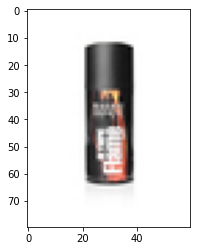

In [8]:
## View the image
image_path = 'myntradataset/images/54967.jpg'#img_files[20]
print(image_path)
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
_ = plt.imshow(input_arr/255)
inputShape = input_arr.shape
print(inputShape)

In [9]:
## Check styles.csv
!head 'myntradataset/styles.csv'

id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt
30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt
26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt
29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks


In [119]:
## Load styles sheets
styles = pd.read_csv('myntradataset/styles.csv', header=None, names=range(11))
styles.drop(columns=10, inplace=True)
styles.columns = styles.iloc[0]
styles = styles.iloc[1:].reset_index(drop=True)
#styles.id = pd.to_numeric(styles['id'])
#styles.year = pd.to_numeric(styles['year'])
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44446 non-null  object
 1   gender              44446 non-null  object
 2   masterCategory      44446 non-null  object
 3   subCategory         44446 non-null  object
 4   articleType         44446 non-null  object
 5   baseColour          44431 non-null  object
 6   season              44425 non-null  object
 7   year                44445 non-null  object
 8   usage               44129 non-null  object
 9   productDisplayName  44439 non-null  object
dtypes: object(10)
memory usage: 3.4+ MB


In [120]:
print('Total number of id (styles):', len(set(styles.id)))
print('Total number of images:', len(set(img_id)))

## Keep the overlaped images==id
no_img = set(styles.id).difference(img_id)
styles = styles[~styles.id.isin(no_img)]
styles.shape

Total number of id (styles): 44446
Total number of images: 44441


(44441, 10)

In [121]:
styles.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch


## Check/refine the Categorical Features

In [122]:
## See Categorical counts at level of masterCategory
styles.masterCategory.value_counts()

Apparel           21395
Accessories       11289
Footwear           9222
Personal Care      2404
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [123]:
cat_sort = styles[['masterCategory','subCategory']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

# cat_repalce = cat_sort[(cat_sort[0]>=105)]['subCategory'].to_list()
# #len(set(cat_repalce))
# set(cat_repalce)

,masterCategory,subCategory,0
0,Apparel,Topwear,15401
1,Footwear,Shoes,7344
2,Accessories,Bags,3055
3,Apparel,Bottomwear,2693
4,Accessories,Watches,2542
5,Apparel,Innerwear,1808
6,Accessories,Jewellery,1080
7,Accessories,Eyewear,1073
8,Personal Care,Fragrance,1012
9,Footwear,Sandal,963


In [124]:
## Set a new Categorical features `Class`

# 1) Keep the masterCategory
styles['Class'] = styles['masterCategory'] 

# 2) if `subCategory` has counts >= 150, keep its category label
cat_sort = styles[['masterCategory', 'subCategory']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

cat_repalce = cat_sort[cat_sort[0] >= 105]['subCategory'].to_list()
row_sel = styles['subCategory'].isin(cat_repalce)
styles.loc[row_sel, 'Class'] = styles.loc[row_sel, 'subCategory']


,masterCategory,subCategory,0
0,Apparel,Topwear,15401
1,Footwear,Shoes,7344
2,Accessories,Bags,3055
3,Apparel,Bottomwear,2693
4,Accessories,Watches,2542
5,Apparel,Innerwear,1808
6,Accessories,Jewellery,1080
7,Accessories,Eyewear,1073
8,Personal Care,Fragrance,1012
9,Footwear,Sandal,963


In [126]:
# 2) if `subCategory` has counts > 1000, we keep the label in `Class`
cat_sort = styles[['Class', 'articleType']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

cat_repalce = cat_sort[cat_sort[0] > 3000]['articleType'].to_list()
row_sel = styles['articleType'].isin(cat_repalce)
styles.loc[row_sel, 'Class'] = styles.loc[row_sel, 'articleType']

print(len(set(styles['Class'])))
set(styles['Class'])

,Class,articleType,0
0,Tshirts,Tshirts,7069
1,Shirts,Shirts,3215
2,Shoes,Casual Shoes,2846
3,Watches,Watches,2542
4,Shoes,Sports Shoes,2036
5,Topwear,Kurtas,1844
6,Topwear,Tops,1762
7,Bags,Handbags,1757
8,Shoes,Heels,1323
9,Eyewear,Sunglasses,1073


32


{'Accessories',
 'Apparel Set',
 'Bags',
 'Belts',
 'Bottomwear',
 'Cufflinks',
 'Dress',
 'Eyewear',
 'Flip Flops',
 'Fragrance',
 'Free Items',
 'Headwear',
 'Home',
 'Innerwear',
 'Jewellery',
 'Lips',
 'Loungewear and Nightwear',
 'Makeup',
 'Nails',
 'Personal Care',
 'Sandal',
 'Saree',
 'Scarves',
 'Shirts',
 'Shoes',
 'Socks',
 'Sporting Goods',
 'Ties',
 'Topwear',
 'Tshirts',
 'Wallets',
 'Watches'}

In [131]:
# 3) If number of items of a Class < 5, then drop it
cat_sort = styles[['Class']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

cat_keep = cat_sort[cat_sort[0] > 5]['Class'].to_list()
cat_keep
row_sel = styles['Class'].isin(cat_keep)
styles = styles.loc[row_sel, :]

print(len(set(styles['Class'])))
set(styles['Class'])

,Class,0
0,Shoes,7344
1,Tshirts,7069
2,Topwear,5118
3,Shirts,3215
4,Bags,3055
5,Bottomwear,2693
6,Watches,2542
7,Innerwear,1808
8,Jewellery,1080
9,Eyewear,1073


31


{'Accessories',
 'Apparel Set',
 'Bags',
 'Belts',
 'Bottomwear',
 'Cufflinks',
 'Dress',
 'Eyewear',
 'Flip Flops',
 'Fragrance',
 'Free Items',
 'Headwear',
 'Innerwear',
 'Jewellery',
 'Lips',
 'Loungewear and Nightwear',
 'Makeup',
 'Nails',
 'Personal Care',
 'Sandal',
 'Saree',
 'Scarves',
 'Shirts',
 'Shoes',
 'Socks',
 'Sporting Goods',
 'Ties',
 'Topwear',
 'Tshirts',
 'Wallets',
 'Watches'}

In [132]:
# Reassign the `Class` to part of the `Free Items` 
# (i.e., these images are not classified properly.)
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Watch'),'Class']='Watches'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Tie'),'Class']='Ties'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Wallet'),'Class']='Wallets'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Sunglasses'),'Class']='Eyewear'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Bag'),'Class']='Bags'
styles.loc[styles['Class'].str.contains('Free') & styles['productDisplayName'].str.contains('Saree'),'Class']='Saree'

styles['image'] = styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
styles.head()

# The rest of free items without Class name. They will be used for prediction.
styles_unkonw = styles[styles['Class'].str.contains('Free')].copy()
print(styles_unkonw.shape)

# The items with well-defined Class. They will be used as train-validation.
styles_know = styles[~styles['Class'].str.contains('Free')].copy()
print(≈.shape)

(20, 12)
(44420, 12)


In [139]:
print('Number of Classes:', len(set(styles_know['Class'])),'\n')
styles_know['Class'].value_counts()


Number of Classes: 30 



Shoes                       7344
Tshirts                     7069
Topwear                     5118
Shirts                      3215
Bags                        3059
Bottomwear                  2693
Watches                     2588
Innerwear                   1808
Eyewear                     1081
Jewellery                   1080
Fragrance                   1012
Sandal                       963
Wallets                      935
Flip Flops                   915
Belts                        810
Socks                        698
Lips                         527
Dress                        478
Loungewear and Nightwear     470
Saree                        444
Accessories                  332
Nails                        329
Makeup                       307
Headwear                     293
Ties                         266
Personal Care                229
Scarves                      118
Cufflinks                    108
Apparel Set                  106
Sporting Goods                25
Name: Clas

Number of classes: 30


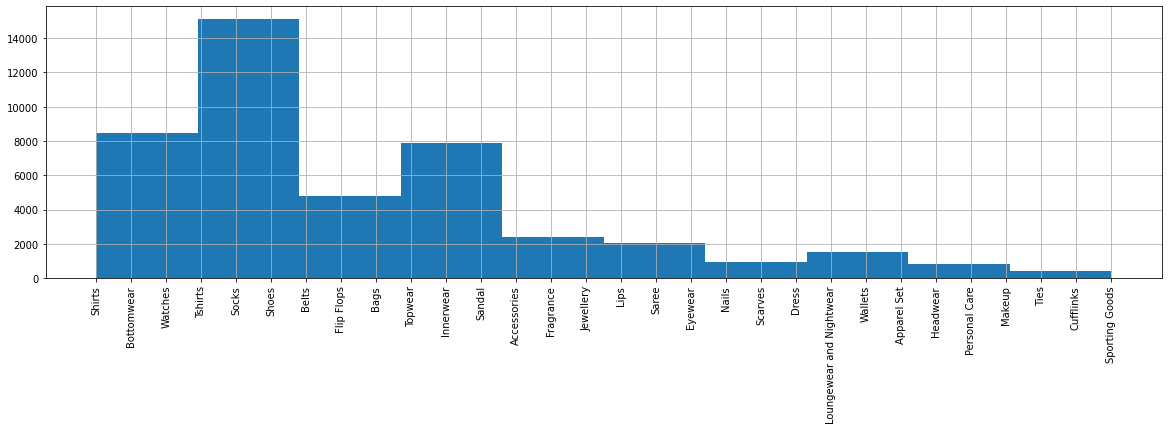

In [140]:
print('Number of classes:', styles_know.Class.value_counts().shape[0])
styles_know.Class.hist(figsize=(20,5))
plt.xticks(rotation=90)
plt.show()

In [20]:
## LabelEncoder
# le = LabelEncoder()
# styles_know['Class_ind'] = le.fit_transform(styles_know['Class'])


## Train & validation, and Test splits

In [157]:
samps_tot = len(styles_know)
rand_ind = np.random.permutation(np.arange(samps_tot))
print('Numebr of total samples)', samps_tot)

# Number of train (70%) & validation (20%) samples = 90%
num_of_tra_vid = samps_tot //10*9
print('Numebr of train (72%) and validation (18%)', num_of_tra_vid)

styles_know_train_valid = styles_know.iloc[rand_ind[:num_of_tra_vid]]
styles_know_test = styles_know.iloc[rand_ind[num_of_tra_vid:]]

print(styles_know_train_valid.shape)
print(styles_know_test.shape)

Numebr of total samples) 44420
Numebr of train (72%) and validation (18%) 39978
(39978, 12)
(4442, 12)


In [158]:
from keras_preprocessing.image import ImageDataGenerator

DATASET_PATH = 'myntradataset/images/'
batch_size = 32

image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True, #, width_shift_range=0.1, height_shift_range=0.1,
)

## Train, validation splits
train_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_train_valid,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=batch_size,
    subset="training"#, color_mode="grayscale"
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_train_valid,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=batch_size,
    shuffle = False,
    subset="validation"#,color_mode="grayscale"
)


Found 31983 validated image filenames belonging to 30 classes.
Found 7995 validated image filenames belonging to 30 classes.


In [169]:
test_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_test,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=1,
    shuffle = False
    )

Found 4442 validated image filenames belonging to 30 classes.


number of classes: 30


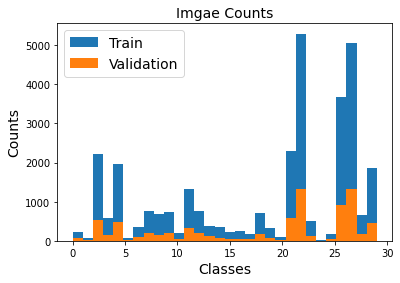

In [159]:
# Number of classes
classes = len(train_generator.class_indices) #len(set(styles_know['Class']))
print("number of classes:", classes)

# Number of images in each class
_ = plt.hist(train_generator.classes, bins=classes, label='Train')
_ = plt.hist(valid_generator.classes, bins=classes, label='Validation')
plt.legend(fontsize=14)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Imgae Counts', fontsize=14)
plt.show()

## Build the CNN classification model

In [160]:
## Build the model using the Keras API
chanDim = -1
model = tf.keras.models.Sequential()

# 1st CONV & RELU => BatchNorm => POOL layer set
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd CONV & RELU => BatchNorm => POOL layer set
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd CONV & RELU => BatchNorm => POOL layer set
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# softmax classifier
model.add(Dense(classes, activation='softmax'))

# initialize the optimizer and complie the model
NUM_EPOCHS = 8
INIT_LR = 1e-2

#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)

model.compile(optimizer=opt,
              loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 80, 60, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 80, 60, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 80, 60, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 80, 60, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 30, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 30, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 40, 30, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [161]:
from keras.callbacks import ModelCheckpoint

## Callback settings
filepath="model_best_color.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Compile and fit
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# Note: make sure to use GPU/TPU on Google Colab.
r=model.fit(x=train_generator, #steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator, #validation_steps=STEP_SIZE_VALID,
            callbacks=callbacks_list,
            epochs=NUM_EPOCHS)

Epoch 1/8
1000/1000 [==============================] - 1000s 999ms/step - loss: 0.7738 - accuracy: 0.7665 - val_loss: 0.8738 - val_accuracy: 0.7079

Epoch 00001: val_accuracy improved from -inf to 0.70794, saving model to model_best_color.h5
Epoch 2/8
1000/1000 [==============================] - 985s 985ms/step - loss: 0.4444 - accuracy: 0.8615 - val_loss: 0.8697 - val_accuracy: 0.7250

Epoch 00002: val_accuracy improved from 0.70794 to 0.72495, saving model to model_best_color.h5
Epoch 3/8
1000/1000 [==============================] - 987s 987ms/step - loss: 0.3549 - accuracy: 0.8862 - val_loss: 4.2084 - val_accuracy: 0.7847

Epoch 00003: val_accuracy improved from 0.72495 to 0.78474, saving model to model_best_color.h5
Epoch 4/8
1000/1000 [==============================] - 986s 986ms/step - loss: 0.3096 - accuracy: 0.9000 - val_loss: 0.8727 - val_accuracy: 0.7342

Epoch 00004: val_accuracy did not improve from 0.78474
Epoch 5/8
1000/1000 [==============================] - 986s 986ms/s

In [ ]:
# model.fit(x_train, y_train, epochs=10, callbacks=callbacks_list, batch_size=32,
#           validation_data=(x_test, y_test))

In [194]:
## Save model
#model.save('my_model.h5')

# Load model
model_best = tf.keras.models.load_model('model_best_color.h5')

# Check its architecture
model_best.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 80, 60, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 80, 60, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 80, 60, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 80, 60, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 40, 30, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 30, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 40, 30, 64)       

## Model Evaluation

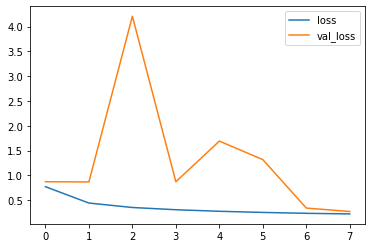

In [162]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [79]:
# The accuracy for validation set
model_best.evaluate(valid_generator, batch_size=1)


278/278 [==============================] - 62s 223ms/step - loss: 0.2756 - accuracy: 0.9182


[0.2755727171897888, 0.9181674718856812]

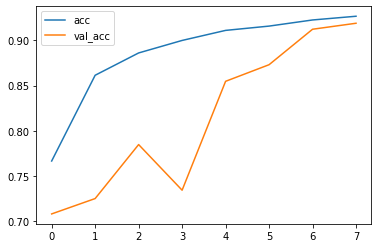

In [163]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [181]:
from sklearn.metrics import confusion_matrix, classification_report#, plot_confusion_matrix
import numpy as np
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  Code from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)

  plt.figure(figsize=(24, 20))
  ax = plt.gca()
  sns.heatmap(cm, annot=True, fmt="d", linewidths=.01, cmap=cmap, #"YlGnBu", 
            xticklabels=classes,
            yticklabels=classes,
            ax=ax)
  
  ax.set_title(title)
  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')
  plt.tight_layout()
  
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(im, cax=cax)
  plt.show()

In [187]:
#labels = {v: k for k, v in train_generator.class_indices.items()}
labels = {v: k for k, v in valid_generator.class_indices.items()}
labels

{0: 'Accessories',
 1: 'Apparel Set',
 2: 'Bags',
 3: 'Belts',
 4: 'Bottomwear',
 5: 'Cufflinks',
 6: 'Dress',
 7: 'Eyewear',
 8: 'Flip Flops',
 9: 'Fragrance',
 10: 'Headwear',
 11: 'Innerwear',
 12: 'Jewellery',
 13: 'Lips',
 14: 'Loungewear and Nightwear',
 15: 'Makeup',
 16: 'Nails',
 17: 'Personal Care',
 18: 'Sandal',
 19: 'Saree',
 20: 'Scarves',
 21: 'Shirts',
 22: 'Shoes',
 23: 'Socks',
 24: 'Sporting Goods',
 25: 'Ties',
 26: 'Topwear',
 27: 'Tshirts',
 28: 'Wallets',
 29: 'Watches'}

### (1) Evaluation on Validation set

In [223]:
# Prediction on validation set
p_test = model_best.predict(valid_generator).argmax(axis=1)

# True labels of validation set
y_test = list(valid_generator.classes)
len(y_test)

7995

In [224]:
# Collect the test images: x_test
x, _ = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_test = np.vstack(x)

# x, y_train = zip(*(train_generator[i] for i in range(len(train_generator))))
# x_train = np.vstack(x)
# y_train = np.vstack(y_train).argmax(axis=1).tolist()

In [51]:
# import pickle

# ## Save the train test set
# image_train_valid = {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}

# with open('train_test_img.pickle', 'wb') as handle:
#     pickle.dump(image_train_valid, handle, protocol=pickle.HIGHEST_PROTOCOL)

# image_train_valid.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test'])

Confusion matrix, without normalization


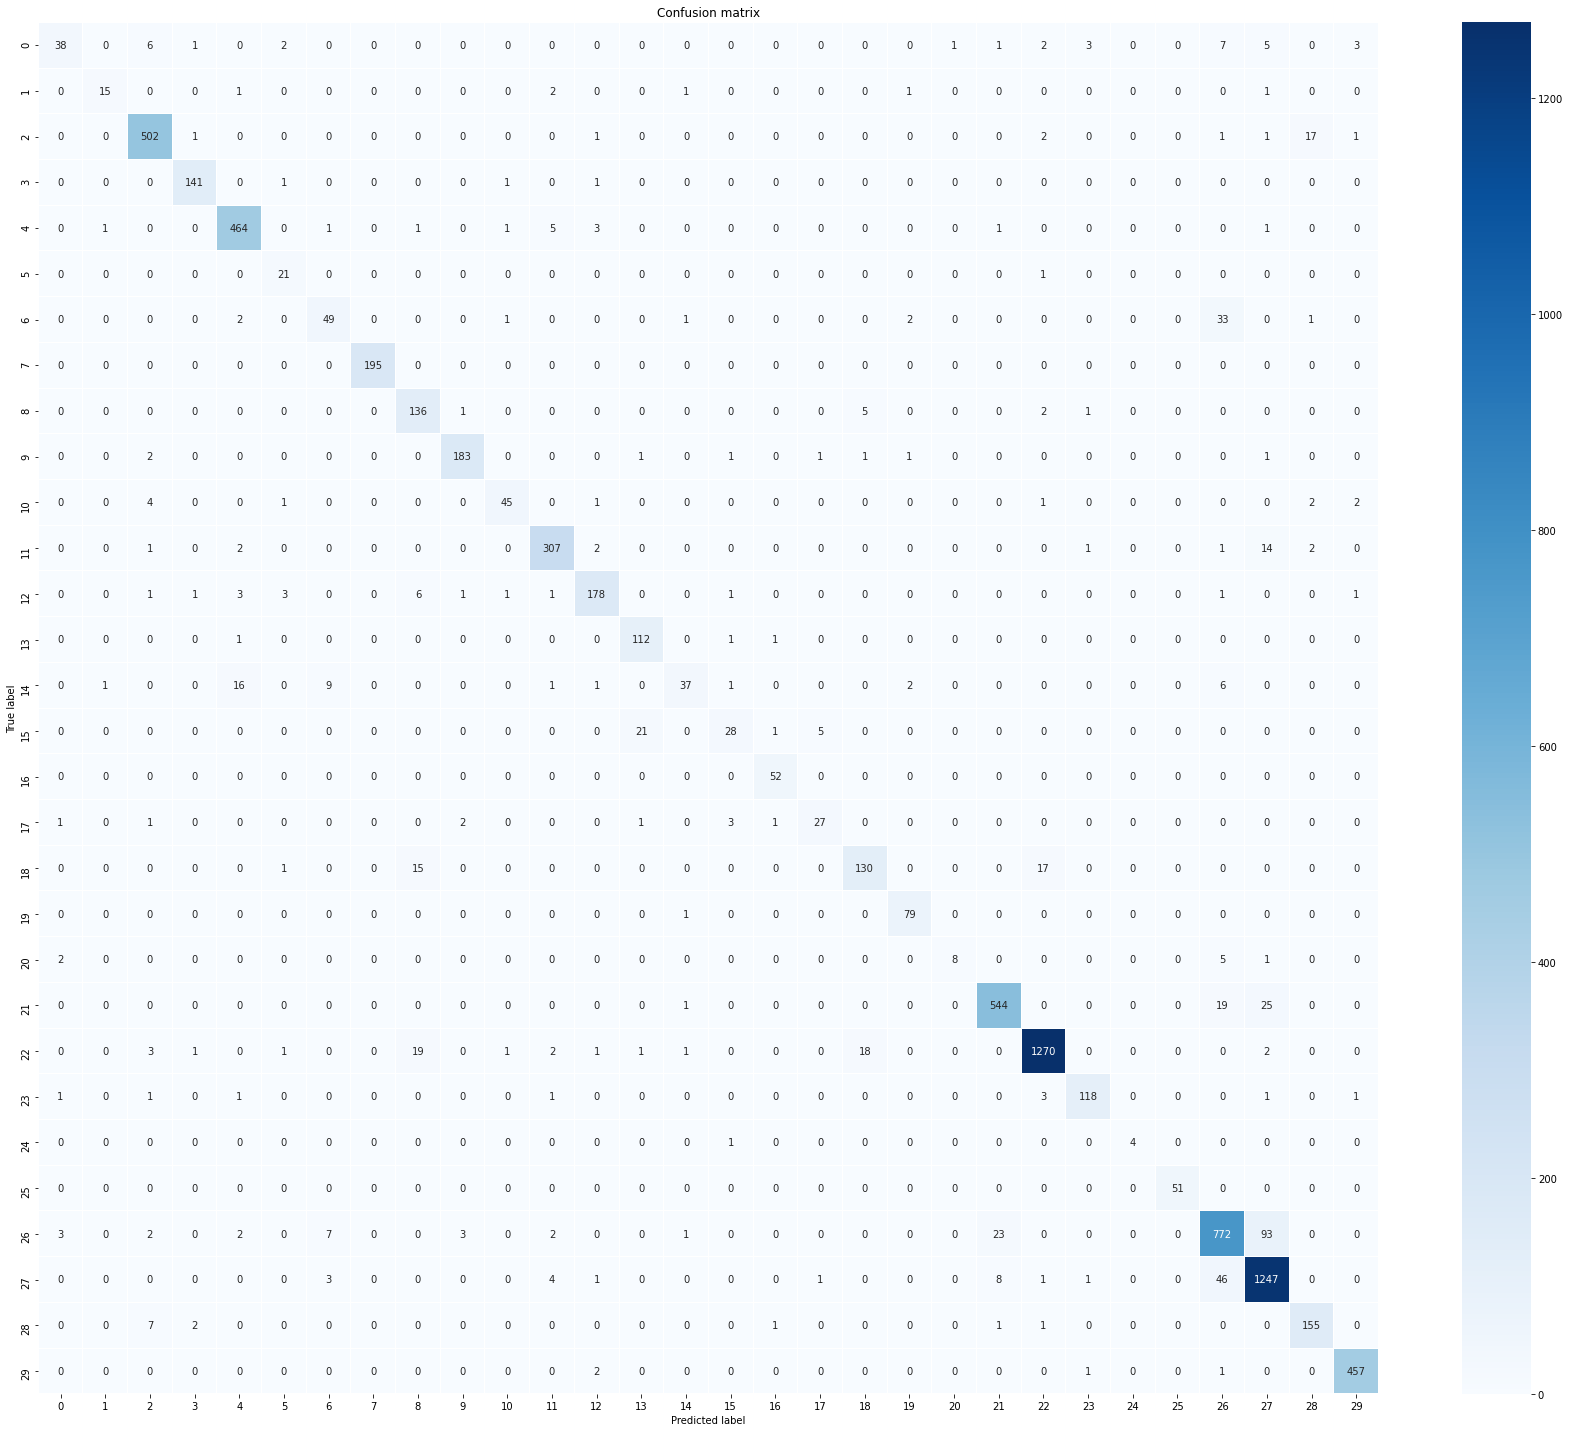

              precision    recall  f1-score   support

           0       0.84      0.55      0.67        69
           1       0.88      0.71      0.79        21
           2       0.95      0.95      0.95       526
           3       0.96      0.98      0.97       144
           4       0.94      0.97      0.96       478
           5       0.70      0.95      0.81        22
           6       0.71      0.55      0.62        89
           7       1.00      1.00      1.00       195
           8       0.77      0.94      0.84       145
           9       0.96      0.96      0.96       191
          10       0.90      0.80      0.85        56
          11       0.94      0.93      0.94       330
          12       0.93      0.90      0.92       198
          13       0.82      0.97      0.89       115
          14       0.86      0.50      0.63        74
          15       0.78      0.51      0.62        55
          16       0.93      1.00      0.96        52
          17       0.79    

In [231]:
# Plot confusion matrix
#class_name = [labels[i] for i in list(set(valid_generator.classes))]
labels = {v: k for k, v in valid_generator.class_indices.items()}
cm = tf.math.confusion_matrix(y_test, p_test).numpy() #confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, labels)
print(classification_report(y_test, p_test))
clsf_report = pd.DataFrame(classification_report(y_test, p_test, output_dict=True)).transpose()
clsf_report.to_csv('ClassiReport_Valid.csv', index=True)


In [226]:
# Label comparison
print('Number of misclassified images:', np.sum(p_test != y_test))
print('Percentage of misclassified images: %.3f' % (np.mean(p_test != y_test)))

Number of misclassified images: 630
Percentage of misclassified images: 0.079


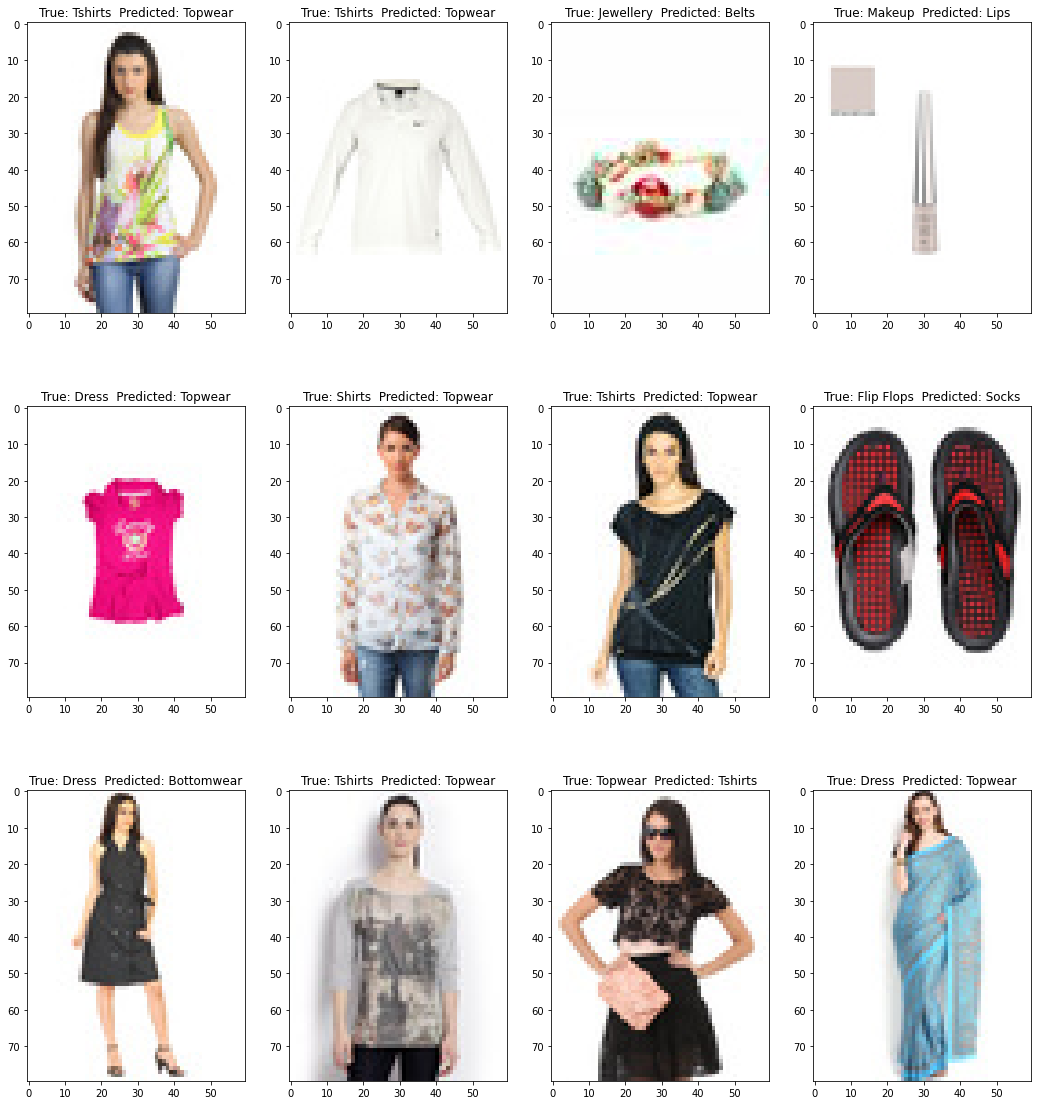

In [228]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]

fig, axes = plt.subplots(3, 4, figsize=(18, 20))
for i, img in enumerate(np.random.choice(misclassified_idx, 12)):
  ax = axes.flat[i]
  ax.imshow(x_test[img])#, cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
plt.show()

### (2) Evaluation on Hold-on set

In [234]:
# Prediction on hold-on set
p_test = model_best.predict(test_generator).argmax(axis=1)

# True labels of hold-on set
y_test = list(test_generator.classes)
len(y_test)

4442

In [235]:
# Collect the test images: x_test
x, _ = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test = np.vstack(x)

Confusion matrix, without normalization


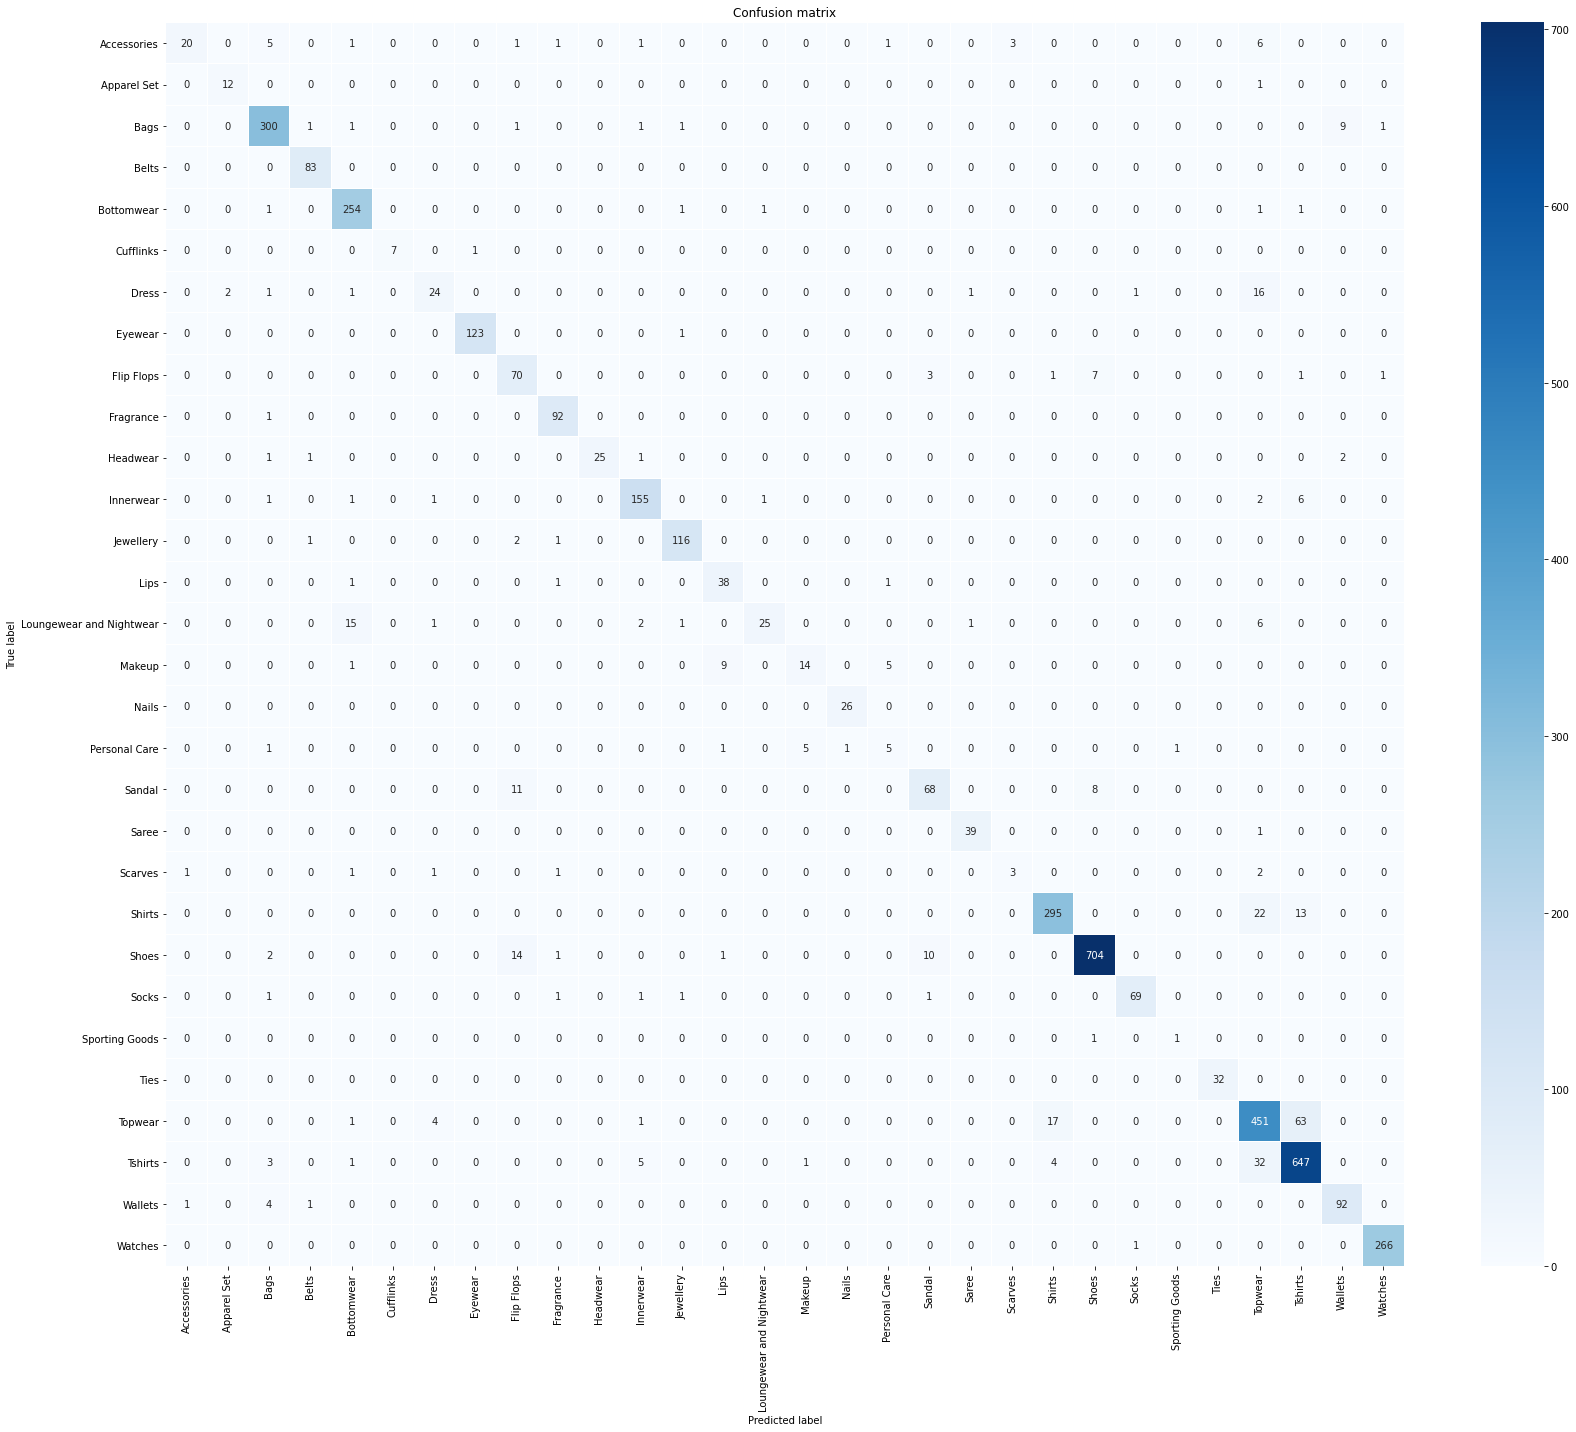

              precision    recall  f1-score   support

           0       0.91      0.51      0.66        39
           1       0.86      0.92      0.89        13
           2       0.93      0.95      0.94       315
           3       0.95      1.00      0.98        83
           4       0.91      0.98      0.95       259
           5       1.00      0.88      0.93         8
           6       0.77      0.52      0.62        46
           7       0.99      0.99      0.99       124
           8       0.71      0.84      0.77        83
           9       0.94      0.99      0.96        93
          10       1.00      0.83      0.91        30
          11       0.93      0.93      0.93       167
          12       0.96      0.97      0.96       120
          13       0.78      0.93      0.84        41
          14       0.93      0.49      0.64        51
          15       0.70      0.48      0.57        29
          16       0.96      1.00      0.98        26
          17       0.42    

In [240]:
# Plot confusion matrix
class_name = [labels[i] for i in list(set(test_generator.classes))]
#labels = {v: k for k, v in test_generator.class_indices.items()}
cm = tf.math.confusion_matrix(y_test, p_test).numpy() #confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, class_name)
print(classification_report(y_test, p_test))
clsf_report = pd.DataFrame(classification_report(y_test, p_test, output_dict=True)).transpose()
clsf_report.to_csv('ClassiReport_hold.csv', index=True)


In [237]:
# Percentage of misclassified
print('Percentage of misclassified images: %.3f' % (np.mean(p_test != y_test)))

Percentage of misclassified images: 0.087


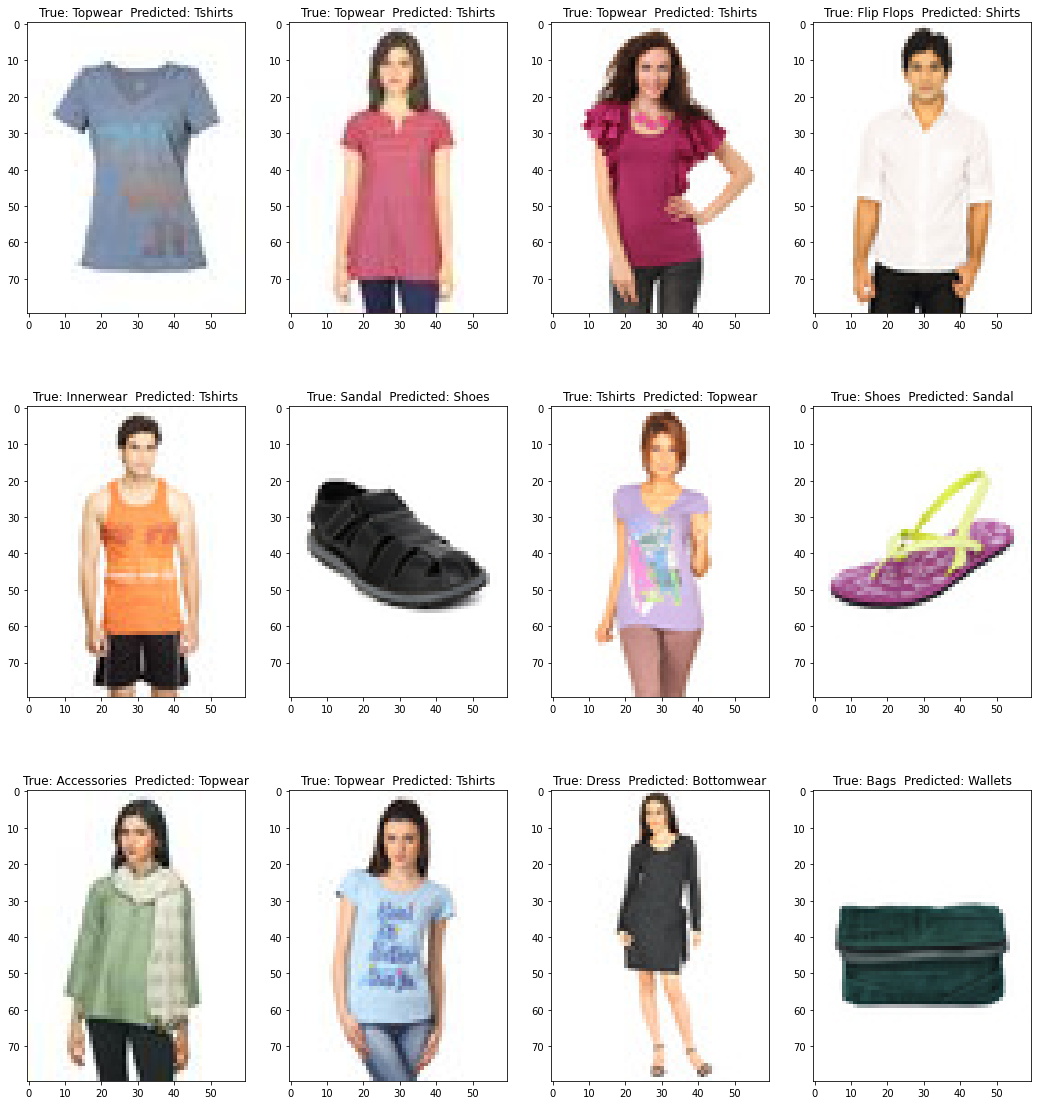

In [238]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]

fig, axes = plt.subplots(3, 4, figsize=(18, 20))
for i, img in enumerate(np.random.choice(misclassified_idx, 12)):
  ax = axes.flat[i]
  ax.imshow(x_test[img])#, cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
plt.show()

## Prediect the Classes for Mislabeled Images

We are going to predict the classes for images lebeled as `Free Items`, listed in the DataFrame `styles_unkonw`. These images are new (not in train and validation sets). As we shell see, for most of the cases the predicted labels match the images.

In [242]:
print(styles_unkonw.shape)
styles_unkonw.head()

(20, 12)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class,image
2663,54970,Women,Free Items,Free Gifts,Free Gifts,Pink,Spring,2017,Casual,Rasasi Women Body Lotion,Free Items,54970.jpg
2871,15349,Men,Free Items,Free Gifts,Free Gifts,Blue,Winter,2012,Sports,Nike Men Blue Team India Cricket Jersey,Free Items,15349.jpg
6816,43285,Women,Free Items,Free Gifts,Backpacks,Black,Summer,2016,Casual,Murcia Women Black Backpack,Free Items,43285.jpg
7924,15658,Unisex,Free Items,Free Gifts,Free Gifts,Blue,Winter,2016,Casual,Belkin Unisex Simple Messenger Blue Handbags,Free Items,15658.jpg
12454,45301,Men,Free Items,Free Gifts,Free Gifts,Black,Summer,2012,Formal,Van Heusen Men Black & Brown Reversible Belt,Free Items,45301.jpg


In [221]:
new_generator = image_generator.flow_from_dataframe(
    dataframe=styles_unkonw,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=1,
    shuffle = False#,color_mode="grayscale"
    )

Found 20 validated image filenames belonging to 1 classes.


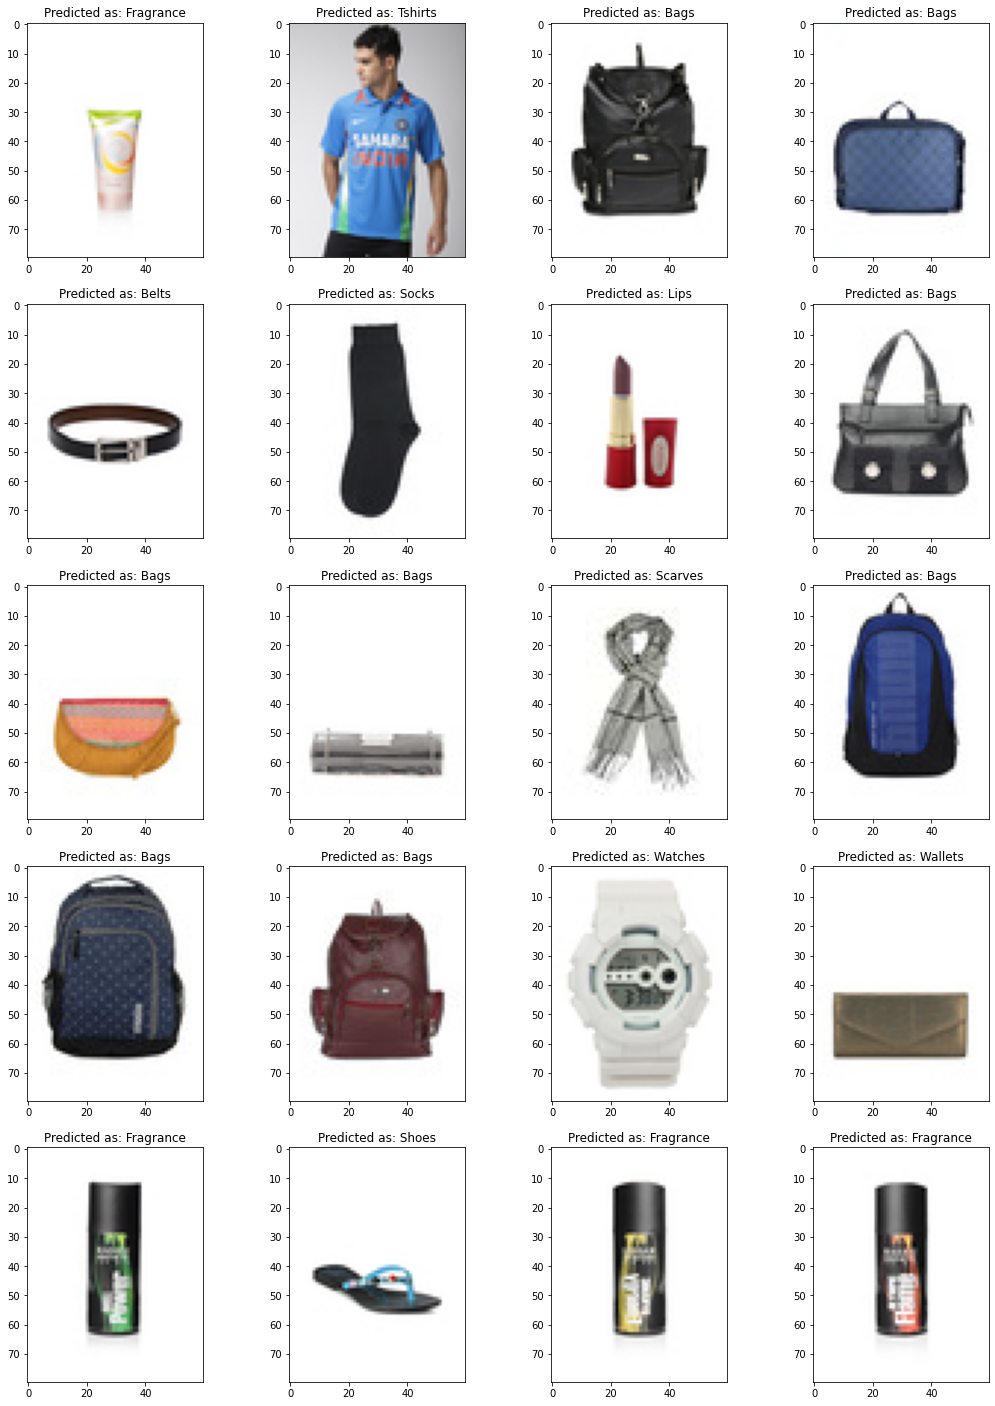

In [222]:
# Predicted labels
p_new = model_best.predict(new_generator).argmax(axis=1)

# Show some new examples
fig, axes = plt.subplots(5, 4, figsize=(18,25))

for i in range(len(new_generator)):
  # New images
  x_new = new_generator[i][0][0]
  
  ax = axes.flat[i]
  #ax.imshow(np.squeeze(x_new, -1), cmap='gray')
  ax.imshow(x_new)
  ax.set_title("Predicted as: %s" % (labels[p_new[i]]))

plt.show()